## 0. 구글 드라이브 연결 및 필수 라이브러리 설치 및 로드

### 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### 필수 라이브러리 설치 및 로드

In [2]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 453 kB 57.3 MB/s 


In [4]:
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nltk
import re

In [5]:
nltk.download()

# 이거 안하면 lookuperror 뜬다.(필요한 것만 지정해서 다운로드 해도되고, all을 사용하여 모두 다운로드 해도 된다.)

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all


       | 
       | Downloading package abc to /root/nltk_data...
       |   Unzipping corpora/abc.zip.
       | Downloading package alpino to /root/nltk_data...
       |   Unzipping corpora/alpino.zip.
       | Downloading package averaged_perceptron_tagger to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger.zip.
       | Downloading package averaged_perceptron_tagger_ru to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
       | Downloading package basque_grammars to /root/nltk_data...
       |   Unzipping grammars/basque_grammars.zip.
       | Downloading package biocreative_ppi to /root/nltk_data...
       |   Unzipping corpora/biocreative_ppi.zip.
       | Downloading package bllip_wsj_no_aux to /root/nltk_data...
       |   Unzipping models/bllip_wsj_no_aux.zip.
       | Downloading package book_grammars to /root/nltk_data...
       |   Unzipping grammars/book_grammars.zip.
       | Downloading 


---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [ ]:
# 이후에 데이터 및 파일들을 저장할 경로를 path로 통일하여 따로 저장

path = '/content/gdrive/MyDrive/Colab Notebooks/CUAI 하계프로젝트-NLP/초기 모델링 진행/data/'

***여기 이후부터는 완료된 단계(4. 토큰화, 5. 정수 인코딩 등)로 점프해서 실행시키면 됨!!***

## 1. 데이터 로드

### 데이터 로드

In [6]:
# '감성대화말뭉치' 엑셀 파일이 저장된 경로에서 엑셀 파일을 로드
train0 = pd.read_excel(path + '감성대화말뭉치(최종데이터)_Training.xlsx', engine='openpyxl')

In [27]:
validation0 = pd.read_excel(path + '감성대화말뭉치(최종데이터)_Validation.xlsx', engine='openpyxl')

### 가져온 데이터 확인

In [28]:
train0.head(2)

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,44164,청년,남성,"연애, 결혼, 출산",해당없음,기쁨,신이 난,아내가 드디어 출산하게 되어서 정말 신이 나.,아내분이 출산을 하시는군요. 정말 축하드려요.,아 지금 정말 신이 나.,잘 된 일이네요.,아기가 점점 클게 벌써 기대가 되네. 내가 많이 놀아줘야지.,좋은 아빠가 되실 거 같아요. 진심으로 축하드려요.,NaN,NaN
1,3926,노년,남성,"건강, 죽음",만성질환 유,불안,스트레스 받는,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,약 종류가 많아 번거로우시겠어요.,건강할 때 관리 좀 잘할걸 하는 생각이 들더라고.,현재 상황에서 변화를 주기 위해 어떻게 하면 될까요?,약을 잘 챙겨 먹고 나을 수 있도록 노력해야지.,약을 잘 챙겨 먹어 건강해지시길 바랄게요.,NaN,NaN


In [29]:
validation0.head(2)

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,23093,청년,여성,"진로, 취업, 직장",해당없음,분노,툴툴대는,요즘 부모님과 많이 부딪혀.,어떤 일로 부딪히시나요?,난 하고 싶은 일이 있는데 부모님은 안정적인 일만 하라고 하셔. 내 마음대로 하지도...,부모님과의 충돌로 힘드시겠군요.,응. 그래도 난 내가 하고 싶은 일을 위해 노력할 거야.,자신이 하고 싶은 일을 목표로 하기로 하셨군요.,NaN,NaN
1,32848,청소년,남성,가족관계,해당없음,슬픔,비통한,엄마가 결국 집을 나갔어. 너무 너무 슬퍼.,어머니께서 집을 나가셨다니 정말 슬프셨겠어요. 좀 더 자세히 얘기해주시겠어요?,엄마도 엄마만의 인생이 있을 테니 가지 말라고 할 수가 없었어. 그래서 더 마음이 ...,정말 많이 답답하셨겠어요. 어떻게 하는 게 기분이 좀 풀릴까요?,일단 좀 자야겠어.,일단 휴식을 가질 생각이시군요.,NaN,NaN


### sample 개수 확인

In [30]:
print('train0의 sample의 수: {}개'.format(train0.shape[0]))
print('validation0의 sample의 수: {}개'.format(validation0.shape[0]))
print('AIHub 샘플의 수: {}개'.format(train0.shape[0]+validation0.shape[0]))

train0의 sample의 수: 40879개
validation0의 sample의 수: 5130개
AIHub 샘플의 수: 46009개


## 2. 데이터 정제

### AI-Hub(train0,validation0) 데이터 전처리

1. 결측값 제거(+필요한 열만 추리기)

In [31]:
# 결측값 개수 확인

print(train0.isnull().sum())
print('-'*20)
print(validation0.isnull().sum())

번호            0
연령            0
성별            0
상황키워드         0
신체질환          0
감정_대분류        0
감정_소분류        0
사람문장1         0
시스템응답1        0
사람문장2         0
시스템응답2        0
사람문장3      9820
시스템응답3     9820
사람문장4     39407
시스템응답4    39517
dtype: int64
--------------------
번호           0
연령           0
성별           0
상황키워드        0
신체질환         0
감정_대분류       0
감정_소분류       0
사람문장1        0
시스템응답1       0
사람문장2        0
시스템응답2       0
사람문장3     1256
시스템응답3    1256
사람문장4     4979
시스템응답4    4994
dtype: int64


사용하려 했던 사람문장 1,2에는 결측이 없으므로  
필요한 열만 가져온 뒤 감정label도 0,1로 형태 변경

In [32]:
# 감정_대분류 표현의 종류 확인 -> 긍정 표현:1, 부정 표현:0으로 변경 예정

print(train0['감정_대분류'].value_counts())
print('-'*20)
print(validation0['감정_대분류'].value_counts())

# 출력결과 train0에는 불안과 기쁨이 2종류로 존재하는데
# 이는 불안과 기쁨 뒤에 공백이 존재하는 것들이 끼어있어 그런 것

불안     7328
분노     6920
슬픔     6915
기쁨     6730
상처     6624
당황     6360
불안        1
기쁨        1
Name: 감정_대분류, dtype: int64
--------------------
불안    907
분노    873
슬픔    861
기쁨    841
당황    832
상처    816
Name: 감정_대분류, dtype: int64


In [33]:
# 필요한 열만 가져와 각각 train1, validation1에 저장

train1 = train0[['감정_대분류', '사람문장1', '사람문장2']]
validation1 = validation0[['감정_대분류', '사람문장1', '사람문장2']]

In [34]:
# 전체 감정label을 0으로 우선 만든 뒤 '기쁨'에 해당하는 것만 1로 변경

train1['label'] = 0
validation1['label'] = 0

train1.loc[train1['감정_대분류']=='기쁨', 'label'] = 1
train1.loc[train1['감정_대분류']=='기쁨 ', 'label'] = 1
validation1.loc[validation1['감정_대분류']=='기쁨', 'label'] = 1
validation1.loc[validation1['감정_대분류']=='기쁨 ', 'label'] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [35]:
# train1 확인

train1.tail(2)

,감정_대분류,사람문장1,사람문장2,label
40877,기쁨,이렇게 좋은 운동 시설에서 경로 우대로 운동할 수 있다니 참 행운이야.,덕분에 건강도 챙길 수 있고 너무 좋아. 안마기도 있던데 내일은 운동하고 안마기도 ...,1
40878,불안,친구 관계가 너무 힘들어. 베푸는 만큼 돌아오지 않는 것 같아.,카페에 가서 대화하거나 같이 술 마시면서 이야기했던 것 같아.,0


In [36]:
# validation1 확인

validation1.tail(2)

,감정_대분류,사람문장1,사람문장2,label
5128,분노,은행 대출이 막혀서 생활비를 구할 수가 없어. 이제 어떻게 살아야 하나 막막해.,당장 내일 밥은 어떡하고 내 병원비는 어쩌지.,0
5129,분노,자식들은 키워 준 은혜도 모르고 내게 오지도 않네. 너무 외롭고 슬퍼.,응 이제 다들 독립해가지고 명절 아니면 찾아오질 않아. 안부전화라도 해주면 좋을 텐데.,0


In [37]:
# 결측 없는지 최종 확인

print(train1.isnull().sum())
print('-'*20)
print(validation1.isnull().sum())

감정_대분류    0
사람문장1     0
사람문장2     0
label     0
dtype: int64
--------------------
감정_대분류    0
사람문장1     0
사람문장2     0
label     0
dtype: int64


2. 중복값 제거

In [38]:
# 전체 행과 열의 수 확인

print(train1.shape)
print(validation1.shape)

(40879, 4)
(5130, 4)


In [39]:
# 사람문장1, 사람문장2, label의 종류 확인

print(train1['사람문장1'].nunique(), train1['사람문장2'].nunique(), train1['label'].nunique())
print(validation1['사람문장1'].nunique(), validation1['사람문장2'].nunique(), validation1['label'].nunique())

# 행의 수와 사람문장의 종류의 수가 같지 않다는 것은
# 중복된 문장이 들어가 있다는 뜻!

39415 38878 2
5103 5096 2


In [40]:
# 중복 제거

train1.drop_duplicates(subset=['사람문장1'], inplace=True, ignore_index=True)
train1.drop_duplicates(subset=['사람문장2'], inplace=True, ignore_index=True)

validation1.drop_duplicates(subset=['사람문장1'], inplace=True, ignore_index=True)
validation1.drop_duplicates(subset=['사람문장2'], inplace=True, ignore_index=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [41]:
# 중복 제거 확인

print(train1.shape[0], train1['사람문장1'].nunique(), train1['사람문장2'].nunique())
print(validation1.shape[0], validation1['사람문장1'].nunique(), validation1['사람문장2'].nunique())

38713 38713 38713
5095 5095 5095


3. 하나의 document의 문장 개수 확인(사람문장1, 사람문장2 분리 포함)

In [42]:
# train1을 사람문장1(train2_1), 사람문장2(train2_2)로 분리(validation도 동일)

train2_1 = train1[['사람문장1', 'label']]
train2_2 = train1[['사람문장2', 'label']]
validation2_1 = validation1[['사람문장1', 'label']]
validation2_2 = validation1[['사람문장2', 'label']]

In [43]:
# 문장 개수 파악에 사용할 sent_tokenize를 import

from nltk.tokenize import sent_tokenize

In [44]:
# 작동 방식 예시

len(sent_tokenize('안녕. 나는 오창준이야'))

# 마침표(.)를 기준으로 문장을 구분

2

In [45]:
train2_1['nsent'] = train2_1['사람문장1'].map(sent_tokenize).map(len)
train2_2['nsent'] = train2_2['사람문장2'].map(sent_tokenize).map(len)
validation2_1['nsent'] = validation2_1['사람문장1'].map(sent_tokenize).map(len)
validation2_2['nsent'] = validation2_2['사람문장2'].map(sent_tokenize).map(len)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [46]:
train2_1.head(2)

,사람문장1,label,nsent
0,아내가 드디어 출산하게 되어서 정말 신이 나.,1,1
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,0,1


In [47]:
# 문장 개수 확인
print(train2_1['nsent'].value_counts())
print('-'*30)
print(train2_2['nsent'].value_counts())
print('-'*30)
print(validation2_1['nsent'].value_counts())
print('-'*30)
print(validation2_2['nsent'].value_counts())

1    28421
2    10033
3      239
4       20
Name: nsent, dtype: int64
------------------------------
1    24254
2    13612
3      779
4       58
5        9
6        1
Name: nsent, dtype: int64
------------------------------
1    3810
2    1238
3      45
4       2
Name: nsent, dtype: int64
------------------------------
1    3250
2    1724
3     116
4       5
Name: nsent, dtype: int64


In [48]:
train2_1.loc[train2_1['nsent']==2].head()

# 문장이 2개인 경우, 보통 '감정 + 그 이유'의 형식을 갖고 있다.
# 즉, 문장이 2개인 경우는 분리해서 사용하면 될듯
# 물론 위와 같은 형식이 아닌 경우도 존재한다. 직접 지워줄 수 있는대로 지워주자

# dataframe을 넣으면 모든 문장을 쪼갠 dataframe을 반환하는 함수를 만들면 좋을듯

,사람문장1,label,nsent
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,1,2
8,친구들이 나를 괴롭혀. 부모님과 선생님께 얘기했는데도 믿어주지 않아.,0,2
10,새로 간 치과에서 조금 썩기만 한 이를 임플란트를 하라고 했어. 과잉진료는 안 한다더니.,0,2
13,아내의 건강이 갑자기 악화됐어. 너무 걱정스럽고 불안해.,0,2
16,이번에도 고시에 불합격했어. 부모님께 무슨 소리를 들을지 벌써부터 두려워.,0,2


In [49]:
train2_1.loc[train2_1['nsent']==3].head()

# 문장이 3개인 경우부터는 모든 문장들이 동일한 감정을 나타내지 않거나 애매한 경우가 존재하므로
# 문장이 3개 이상인 것들은 아예 제외하는 것이 낫다고 판단

,사람문장1,label,nsent
90,정년퇴직을 하게 되었어. 노후 준비를 다 해놔서 그런지 두렵지 않아. 너무 기뻐.,1,3
95,요즘 내 진로에 대해서 고민이 많아. 명확한 꿈이 없어. 혼란스러워.,0,3
187,오빠는 일이 없나 봐. 항상 혼자 방에 틀어박혀 있어. 그런 오빠가 좀 걱정돼.,0,3
368,항상 피로감은 있었지만 간암일 줄이야. 병원에서 죽을 수도 있다는데 참혹하고 화가 ...,0,3
636,내 주위에 괴롭힘을 당하는 친구가 있어. 분명 나에게 도움을 청할 거야. 난 그렇게...,1,3


In [50]:
# 문장 개수가 2개 이하인 것들만 새로운 변수에 저장

train3_1 = train2_1.loc[train2_1['nsent']<=2]
train3_2 = train2_2.loc[train2_2['nsent']<=2]
validation3_1 = validation2_1.loc[validation2_1['nsent']<=2]
validation3_2 = validation2_2.loc[validation2_2['nsent']<=2]

In [51]:
train3_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38454 entries, 0 to 38712
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   사람문장1   38454 non-null  object
 1   label   38454 non-null  int64 
 2   nsent   38454 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ MB


In [52]:
train3_1.tail()

,사람문장1,label,nsent
38708,최 영감이 노인들에게 나를 이상한 사람으로 이야기해서 답답하고 억울해.,0,1
38709,지난주에 건강검진 결과가 나왔는데 정상이라고 결과가 나왔어.,1,1
38710,엄마는 내 꿈인 작가를 응원해 주고는 했는데 지금은 안 그래. 너무 슬퍼.,0,2
38711,이렇게 좋은 운동 시설에서 경로 우대로 운동할 수 있다니 참 행운이야.,1,1
38712,친구 관계가 너무 힘들어. 베푸는 만큼 돌아오지 않는 것 같아.,0,2


In [53]:
# 사람문장이라는 열 이름을 document로 변경
train3_1.columns = ['document', 'label', 'nsent']
train3_2.columns = ['document', 'label', 'nsent']
validation3_1.columns = ['document', 'label', 'nsent']
validation3_2.columns = ['document', 'label', 'nsent']

In [54]:
train3_1 = train3_1.reset_index()
train3_2 = train3_2.reset_index()
validation3_1 = validation3_1.reset_index()
validation3_2 = validation3_2.reset_index()

In [55]:
train3_1.tail()

,index,document,label,nsent
38449,38708,최 영감이 노인들에게 나를 이상한 사람으로 이야기해서 답답하고 억울해.,0,1
38450,38709,지난주에 건강검진 결과가 나왔는데 정상이라고 결과가 나왔어.,1,1
38451,38710,엄마는 내 꿈인 작가를 응원해 주고는 했는데 지금은 안 그래. 너무 슬퍼.,0,2
38452,38711,이렇게 좋은 운동 시설에서 경로 우대로 운동할 수 있다니 참 행운이야.,1,1
38453,38712,친구 관계가 너무 힘들어. 베푸는 만큼 돌아오지 않는 것 같아.,0,2


In [56]:
# 예전에 순서가 안맞던 인덱스가 index라는 열로 새로 생겨서 다시 한번 필요한 열만 새로운 변수에 저장

train4_1 = train3_1[['document', 'label']]
train4_2 = train3_2[['document', 'label']]
validation4_1 = validation3_1[['document', 'label']]
validation4_2 = validation3_2[['document', 'label']]

In [57]:
# 확인
train4_1.tail()

,document,label
38449,최 영감이 노인들에게 나를 이상한 사람으로 이야기해서 답답하고 억울해.,0
38450,지난주에 건강검진 결과가 나왔는데 정상이라고 결과가 나왔어.,1
38451,엄마는 내 꿈인 작가를 응원해 주고는 했는데 지금은 안 그래. 너무 슬퍼.,0
38452,이렇게 좋은 운동 시설에서 경로 우대로 운동할 수 있다니 참 행운이야.,1
38453,친구 관계가 너무 힘들어. 베푸는 만큼 돌아오지 않는 것 같아.,0


4. 하나의 document로 묶인 2개의 문장들을 각각 서로 다른 document로 분리(사용자 정의 함수 trans_df 사용)

In [59]:
# 문장 2개를 각각 하나의 문장으로 분리해줄 함수 정의
def trans_df(df):
  temp = pd.DataFrame({'document':[], 'label':[]})
  num = 0
  for i in range(df.shape[0]):
    if(i%5000 == 0):
      print(i,'번째')
    for s in sent_tokenize(df['document'][i]):
      temp.loc[num] = [s, df['label'][i]]
      num = num+1
  return temp

In [60]:
# train 4_1부터 차례대로 문장 분리 작업한 결과물을 새로운 변수에 저장
train5_1 = trans_df(train4_1)

0 번째
5000 번째
10000 번째
15000 번째
20000 번째
25000 번째
30000 번째
35000 번째


In [61]:
train5_2 = trans_df(train4_2)

0 번째
5000 번째
10000 번째
15000 번째
20000 번째
25000 번째
30000 번째
35000 번째


In [62]:
validation5_1 = trans_df(validation4_1)

0 번째
5000 번째


In [63]:
validation5_2 = trans_df(validation4_2)

0 번째


In [64]:
# 확인
train5_1.tail()

,document,label
48482,엄마는 내 꿈인 작가를 응원해 주고는 했는데 지금은 안 그래.,0.0
48483,너무 슬퍼.,0.0
48484,이렇게 좋은 운동 시설에서 경로 우대로 운동할 수 있다니 참 행운이야.,1.0
48485,친구 관계가 너무 힘들어.,0.0
48486,베푸는 만큼 돌아오지 않는 것 같아.,0.0


In [65]:
# 최종 문장 개수 확인
print(train5_1['document'].value_counts())
print('-'*30)
print(train5_2['document'].value_counts())
print('-'*30)
print(validation5_1['document'].value_counts())
print('-'*30)
print(validation5_2['document'].value_counts())

# 이렇게 하니까 document 문장에 있는 것의 동일한 문장 수를 세서 출력했음

너무 슬퍼.                                                      83
너무 화가 나.                                                    75
너무 속상해.                                                     62
너무 기뻐.                                                      48
너무 힘들어.                                                     45
                                                            ..
요즘 어깨가 뻐근하고 쉽게 피로하고 잠을 자도 피곤이 풀리지 않아 혹시 몸에 무슨 문제가 생긴 걸까?     1
오늘 소개팅을 했는데 차였어.                                             1
요즘 너무 외로운 거 같아.                                              1
갖고 싶은 게임기가 생겨서 아빠에게 조심히 물어봤어.                                1
베푸는 만큼 돌아오지 않는 것 같아.                                         1
Name: document, Length: 46287, dtype: int64
------------------------------
응.                                                     1663
맞아.                                                     672
아니.                                                      70
그렇지.                                                

In [66]:
# 다시 최종 문장 개수 확인
print(train5_1.info()) # 48487개 문장
print('-'*30)
print(train5_2.info()) # 51478개 문장
print('-'*30)
print(validation5_1.info()) # 6286개 문장
print('-'*30)
print(validation5_2.info()) # 6698개 문장

# train은 약 10만개, validation은 약 1.2만개 정도 생성됨

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48487 entries, 0 to 48486
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   document  48487 non-null  object 
 1   label     48487 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.1+ MB
None
------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 51478 entries, 0 to 51477
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   document  51478 non-null  object 
 1   label     51478 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.2+ MB
None
------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6286 entries, 0 to 6285
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   document  6286 non-null   object 
 1   label     6286 non-null   float64
dtypes: float64(1), object(1)
memo

5. 사람문장1,2로 나뉘었던 train, validation 데이터를 다시 하나로 합치기

In [97]:
# train5_1, train5_2를 다시 하나의 train6이라는 변수로 합치기(validation도 동일)
train6 = train5_1.append(train5_2, ignore_index=True)
validation6 = validation5_1.append(validation5_2, ignore_index=True)

In [98]:
train6

,document,label
0,아내가 드디어 출산하게 되어서 정말 신이 나.,1.0
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,0.0
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,0.0
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야.,1.0
4,너무 행복해.,1.0
...,...,...
99960,결과가 좋게 나와서 다행이야,1.0
99961,내 재능이 남들보다 월등한 거는 아니라면서 취업해서 안정적으로 살았으면 좋겠다고 하셔.,0.0
99962,덕분에 건강도 챙길 수 있고 너무 좋아.,1.0
99963,안마기도 있던데 내일은 운동하고 안마기도 써볼까?,1.0


In [99]:
validation6

,document,label
0,요즘 부모님과 많이 부딪혀.,0.0
1,엄마가 결국 집을 나갔어.,0.0
2,너무 너무 슬퍼.,0.0
3,학교에서 한 친구를 괴롭히는 무리에게 그만하라고 했어.,0.0
4,이번에 팀장님이 간단한 조사 업무를 부탁하셨는데 내가 잘못 처리했어.,0.0
...,...,...
12979,내가 게을러서 다른 방법을 아직 생각하진 못했어.,0.0
12980,댄스 동호회는 좀 괜찮은 것 같은데 이참에 가입해볼까?,0.0
12981,당장 내일 밥은 어떡하고 내 병원비는 어쩌지.,0.0
12982,응 이제 다들 독립해가지고 명절 아니면 찾아오질 않아.,0.0


In [100]:
# 실수형이 된 label을 다시 정수형으로 변환
train6['label'] = train6['label'].astype('int64')
validation6['label'] = validation6['label'].astype('int64')

In [101]:
# 확인
print(train6.info())
print('-'*30)
print(validation6.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99965 entries, 0 to 99964
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   document  99965 non-null  object
 1   label     99965 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB
None
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12984 entries, 0 to 12983
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   document  12984 non-null  object
 1   label     12984 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 203.0+ KB
None


6. 노이즈 제거(앞서 문장 구분하느라 제거하지 않았던 마침표나 느낌표 같은 문장부호 제거 작업)

In [102]:
# 원문 우선 확인
train6

,document,label
0,아내가 드디어 출산하게 되어서 정말 신이 나.,1
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,0
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,0
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야.,1
4,너무 행복해.,1
...,...,...
99960,결과가 좋게 나와서 다행이야,1
99961,내 재능이 남들보다 월등한 거는 아니라면서 취업해서 안정적으로 살았으면 좋겠다고 하셔.,0
99962,덕분에 건강도 챙길 수 있고 너무 좋아.,1
99963,안마기도 있던데 내일은 운동하고 안마기도 써볼까?,1


In [104]:
train6['document'] = train6['document'].map(lambda sent: re.sub(r'[.,"\'-?:!;]', '', sent))

In [105]:
# 처리 잘 되었는지 확인
train6

,document,label
0,아내가 드디어 출산하게 되어서 정말 신이 나,1
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야,0
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워,0
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야,1
4,너무 행복해,1
...,...,...
99960,결과가 좋게 나와서 다행이야,1
99961,내 재능이 남들보다 월등한 거는 아니라면서 취업해서 안정적으로 살았으면 좋겠다고 하셔,0
99962,덕분에 건강도 챙길 수 있고 너무 좋아,1
99963,안마기도 있던데 내일은 운동하고 안마기도 써볼까,1


In [106]:
# 원문 우선 확인
validation6

,document,label
0,요즘 부모님과 많이 부딪혀.,0
1,엄마가 결국 집을 나갔어.,0
2,너무 너무 슬퍼.,0
3,학교에서 한 친구를 괴롭히는 무리에게 그만하라고 했어.,0
4,이번에 팀장님이 간단한 조사 업무를 부탁하셨는데 내가 잘못 처리했어.,0
...,...,...
12979,내가 게을러서 다른 방법을 아직 생각하진 못했어.,0
12980,댄스 동호회는 좀 괜찮은 것 같은데 이참에 가입해볼까?,0
12981,당장 내일 밥은 어떡하고 내 병원비는 어쩌지.,0
12982,응 이제 다들 독립해가지고 명절 아니면 찾아오질 않아.,0


In [107]:
validation6['document'] = validation6['document'].map(lambda sent: re.sub(r'[.,"\'-?:!;]', '', sent))

In [108]:
# 처리 잘 되었는지 확인
validation6

,document,label
0,요즘 부모님과 많이 부딪혀,0
1,엄마가 결국 집을 나갔어,0
2,너무 너무 슬퍼,0
3,학교에서 한 친구를 괴롭히는 무리에게 그만하라고 했어,0
4,이번에 팀장님이 간단한 조사 업무를 부탁하셨는데 내가 잘못 처리했어,0
...,...,...
12979,내가 게을러서 다른 방법을 아직 생각하진 못했어,0
12980,댄스 동호회는 좀 괜찮은 것 같은데 이참에 가입해볼까,0
12981,당장 내일 밥은 어떡하고 내 병원비는 어쩌지,0
12982,응 이제 다들 독립해가지고 명절 아니면 찾아오질 않아,0


7. 최종적으로 정제된 ai-hub 데이터를 엑셀 파일로 저장

In [115]:
train6.to_excel(path + 'aihub_data_train_preprocessed.xlsx', index=False)

In [116]:
validation6.to_excel(path + 'aihub_data_validation_preprocessed.xlsx', index=False)

In [117]:
# 나중에 결국 nsmc 데이터랑 합쳐서 아예 새롭게 train/validation 나눌 것이므로
# train6, validation6 데이터 합쳐서 하나의 aihub_data로 만들기

aihub_data = train6.append(validation6, ignore_index=True)
aihub_data

,document,label
0,아내가 드디어 출산하게 되어서 정말 신이 나,1
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야,0
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워,0
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야,1
4,너무 행복해,1
...,...,...
112944,내가 게을러서 다른 방법을 아직 생각하진 못했어,0
112945,댄스 동호회는 좀 괜찮은 것 같은데 이참에 가입해볼까,0
112946,당장 내일 밥은 어떡하고 내 병원비는 어쩌지,0
112947,응 이제 다들 독립해가지고 명절 아니면 찾아오질 않아,0


In [118]:
aihub_data.to_excel(path + 'aihub_data_preprocessed.xlsx', index=False)

## 4. 토큰화

### 4-1. 토큰화하기 직전까지 전처리 완료된 파일을 불러오기  
(이유:런타임이 끝났을 때 다시 처음부터 전부 실행할 필요 없이 맨 윗부분의 import 해야하는 것만 실행하고 바로 여기서부터 이어서 실행시켜도 됨!)

In [123]:
# (참고)path 부분은 맨 앞 0장의 마지막 코드에서 경로 지정하였음!
# 전처리된 데이터 로드

aihub_data = pd.read_excel(path + 'aihub_data_preprocessed.xlsx', engine='openpyxl')

In [124]:
aihub_data.tail(3)

,document,label
112946,당장 내일 밥은 어떡하고 내 병원비는 어쩌지,0
112947,응 이제 다들 독립해가지고 명절 아니면 찾아오질 않아,0
112948,안부전화라도 해주면 좋을 텐데,0


### 4-2. konlpy(한국어 NLP)에서 Okt 형태소 분석기를 사용하여 토큰화를 수행

In [121]:
okt = Okt()

# 예시 문장으로 test
okt.morphs('덕분에 건강도 챙길 수 있고 너무 좋아.', stem = True)

['덕분', '에', '건강', '도', '챙기다', '수', '있다', '너무', '좋다', '.']

In [125]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [126]:
aihub_x_train = []
for sentence in tqdm(aihub_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    aihub_x_train.append(stopwords_removed_sentence)

  1%|          | 1387/112949 [00:03<04:13, 439.70it/s]


AssertionError: ignored

In [19]:
aihub_x_train = np.array(aihub_x_train)
np.save(path + 'aihub_x_train.npy', aihub_x_train)

## 5. 정수 인코딩

### 5-1. 정수 인코딩하기 직전까지 전처리 완료된 파일을 불러오기  
(이유:런타임이 끝났을 때 다시 처음부터 전부 실행할 필요 없이 맨 윗부분의 import 해야하는 것만 실행하고 바로 여기서부터 이어서 실행시켜도 됨!)

In [22]:
# (참고)path 부분은 맨 앞 0장의 마지막 코드에서 경로 지정하였음!
# 전처리된 데이터 로드

aihub_x_train = np.load(path + 'aihub_x_train.npy', allow_pickle=True)
aihub_x_validation = np.load(path + 'aihub_x_validation.npy', allow_pickle=True)

In [23]:
aihub_x_train

array([list(['아내', '드디어', '출산', '되어다', '정말', '신', '나', '.']),
       list(['당뇨', '랑', '합병증', '때문', '먹다', '약', '열', '가지', '넘어가다', '스트레스', '야', '.']),
       list(['고등학교', '올라오다', '중학교', '때', '보다', '수업', '갑자기', '어려워지다', '당황', '스럽다', '.']),
       ..., list(['덕분', '건강', '챙기다', '수', '있다', '너무', '좋다', '.']),
       list(['안마', '기도', '있다', '내일', '운동', '하고', '안마', '기도', '써다', '보다', '?']),
       list(['카페', '가다', '대화', '하', '거나', '같이', '술', '말다', '이야기', '것', '같다', '.'])],
      dtype=object)

In [24]:
aihub_x_validation

array([list(['요즘', '부모님', '많이', '부딪히다', '.']),
       list(['엄마', '결국', '집', '을', '나가다', '.']),
       list(['너무', '너무', '슬프다', '.']), ...,
       list(['당장', '내일', '밥', '어떡하다', '내', '병원', '비다', '어쩌지', '.']),
       list(['응', '이제', '다', '들다', '독립', '명절', '아니다', '찾아오다', '않다', '.']),
       list(['안부', '전화', '라도', '해주다', '좋다', '텐데', '.'])], dtype=object)

In [25]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(aihub_x_train)

In [26]:
print(tokenizer.word_index)

{'.': 1, '을': 2, '내': 3, '나': 4, '너무': 5, '있다': 6, '것': 7, '친구': 8, '같다': 9, '없다': 10, '보다': 11, '안': 12, '않다': 13, '되다': 14, '좋다': 15, '못': 16, '에서': 17, '이야': 18, '말': 19, '싶다': 20, '만': 21, '사람': 22, '들다': 23, '받다': 24, '생각': 25, '모르다': 26, '에게': 27, '게': 28, '돼다': 29, '더': 30, '돈': 31, '?': 32, '정말': 33, '일': 34, '자다': 35, '수': 36, '걱정': 37, '하고': 38, '나다': 39, '회사': 40, '그렇다': 41, '다': 42, '로': 43, '많이': 44, '힘들다': 45, '한테': 46, '때': 47, '고': 48, '가다': 49, '어떻다': 50, '나르다': 51, '거': 52, '요즘': 53, '마음': 54, '때문': 55, '아니다': 56, '오늘': 57, '아내': 58, '그': 59, '해': 60, '스럽다': 61, '남편': 62, '결혼': 63, '우리': 64, '기분': 65, '많다': 66, '야': 67, '아프다': 68, '이번': 69, '화가': 70, '적': 71, '오다': 72, '슬프다': 73, '응': 74, '집': 75, '먹다': 76, '이제': 77, '준비': 78, '나이': 79, '나오다': 80, '인데': 81, '왜': 82, '직장': 83, '!': 84, '주다': 85, '라고': 86, '일이': 87, '지금': 88, '건강': 89, '아들': 90, '가족': 91, '다른': 92, '엄마': 93, '불안하다': 94, '되어다': 95, '난': 96, '맞다': 97, '랑': 98, '자식': 99, '부모님': 100, '걸': 101, '자꾸': 102, '까

In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 45411
등장 빈도가 2번 이하인 희귀 단어의 수: 24037
단어 집합에서 희귀 단어의 비율: 52.93210896038405
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.3040748560435425


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 21375


In [ ]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

# 길이가 0인 샘플의 인덱스를 받아온다.

In [ ]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

232653
232653


리뷰의 최대 길이 : 70
리뷰의 평균 길이 : 9.810580564187868


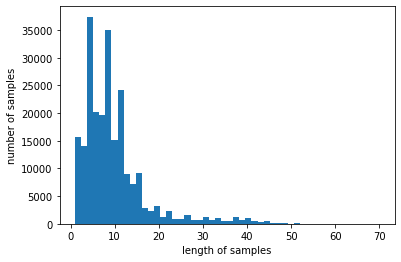

In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 96.35551658478506


In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# padding = 'post'로 하면 뒤에 0이 붙는다.

In [ ]:
print(X_train[:3])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0  372  369   27  315  352 2105
     5    1]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0   32   26  992    8   58 3061   20 1162  138  246
     6  335]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0  745  401    8  256    3  349
  1529  109]]
